# Explore here

In [1]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install xgboost
!pip install statsmodels
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [29]:
import pandas as pd
import numpy as np
from numpy.random import seed, choice
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier 
from imblearn.metrics import specificity_score
from sklearn.model_selection import GridSearchCV
import joblib

In [3]:
# Cargamos lsos datos
url = 'https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv'
df =pd.read_csv(url)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Comprobamos tamaño del dataframe
df.shape

(768, 9)

In [6]:
#Comprobamos tipos de variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
# Comprobamos duplicados
df.duplicated().sum()

np.int64(0)

In [8]:
# Comprobamos valores nulos
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [9]:
# Comprobamos valores únicos
df.nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

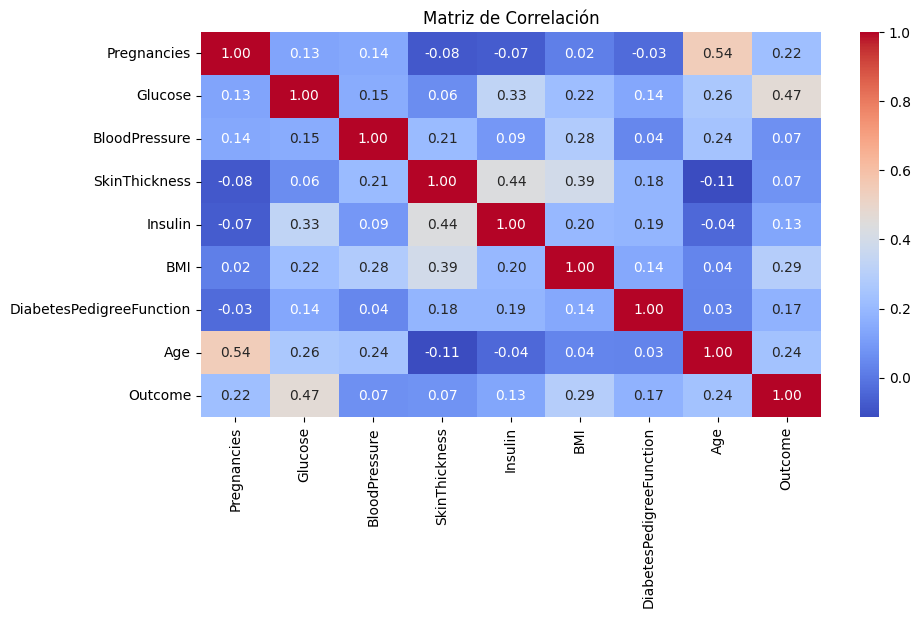

In [10]:
# Matriz de Correlación
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

De la gráfica anterior observamos lo siguiente:

- La edad está muy relacionada con el número de embarazos (pregnancies)
- La glucosa está muy relacionada con el resultado
- La Insulina está muy relacionada con el grosor de la piel (skinthickness)

In [11]:
# Identificamos valores influyentes
X = df.drop(['Outcome'], axis =1)
y = df['Outcome']
X = sm.add_constant(X)
model = sm.OLS(y,X).fit()
cooks_distance = model.get_influence().cooks_distance

# Punto de corte distancia cook
punto_corte = 4 / len(df)
print("Punto de corte para la distancia de Cook:", punto_corte)

# Eliminamos observaciones que superan el punto de corte
df_noinflu = df.drop(np.where(cooks_distance[0]>punto_corte)[0])
df_noinflu.head()

Punto de corte para la distancia de Cook: 0.005208333333333333


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


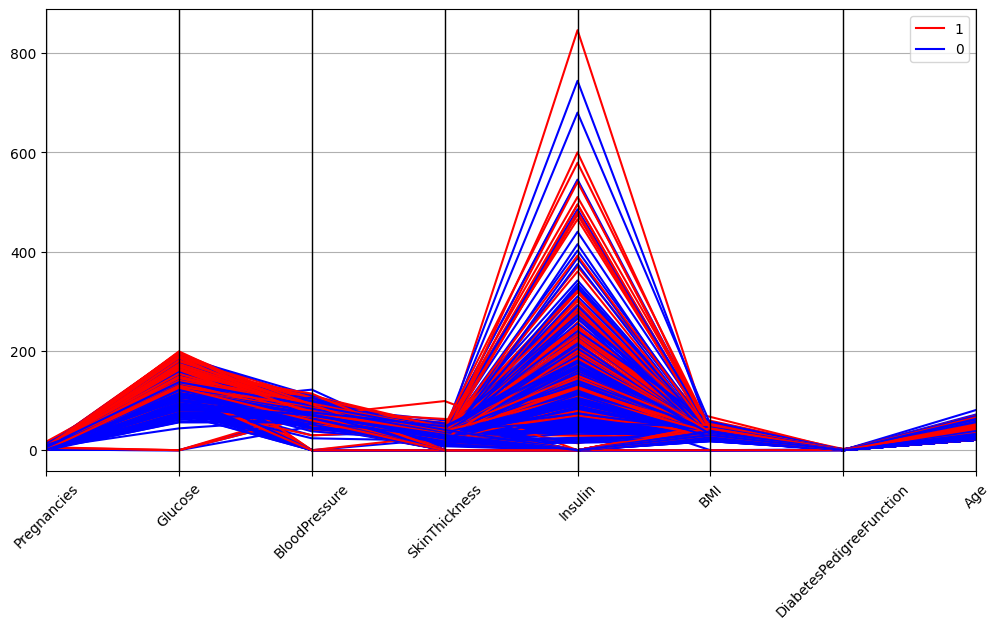

In [12]:
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()

In [13]:
# Partición de los datos
X = df.drop(columns=["Outcome"])
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Selección de características importantes con XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

importancias = xgb_model.feature_importances_
importancias_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importancias})
importancias_df = importancias_df[importancias_df["Importance"] > 0.01]  # Mayor al 1%

print("Características seleccionadas:")
print(importancias_df)

Características seleccionadas:
                    Feature  Importance
0               Pregnancies    0.092735
1                   Glucose    0.259786
2             BloodPressure    0.082359
3             SkinThickness    0.092384
4                   Insulin    0.102135
5                       BMI    0.135555
6  DiabetesPedigreeFunction    0.096436
7                       Age    0.138610


In [19]:
# Definimos la clase RF
class RandomForestCustom:

  def __init__(self, n_estimators, random_state, max_depth, min_samples_leaf, max_features, X, y):
    self.n_estimators = n_estimators
    self.random_state = random_state
    self.max_depth = max_depth
    self.min_samples_leaf = min_samples_leaf
    self.max_features = max_features
    self.X = X
    self.y = y
    self.models = []

  def get_bootstrap_datasets(self):
    seed(self.random_state)
    # Seleccionar aleatoriamente las filas que vamos a usar para entrenar cada árbol
    idxs = [choice(len(self.X), len(self.X), replace=True) for _ in range(self.n_estimators)]
    # Seleccionar aleatoriamente las columnas que vamos a usar para entrenar cada árbol
    feature_idxs = [choice(range(self.X.shape[1]), self.max_features, replace=False) for _ in range(self.n_estimators)]
    return feature_idxs, [(self.X[idxs[i],:][:,feature_idxs[i]], self.y[idxs[i]]) for i in range(self.n_estimators)]
  
  def fit(self):
    feature_idxs, data_sets = self.get_bootstrap_datasets()
    for i, data in enumerate(data_sets):
      X_i, y_i = data
      tree_i = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.min_samples_leaf, max_features=self.max_features, random_state=self.random_state).fit(X_i, y_i)
      self.models.append((feature_idxs[i], tree_i))

  def predict(self, X):
    predictions = np.vstack([model.predict(X[:,idxs]) for idxs, model in self.models])
    predicciones = [Counter(predictions[:,i]).most_common(1)[0][0] for i in range(predictions.shape[1])]
    return predicciones

In [21]:
# Creamos un random forest simple y otro complejo
random_forest_simp = RandomForestCustom(n_estimators=4, random_state=42, max_depth=2, min_samples_leaf=20, max_features=X_train.shape[1], X=X_train.values, y=y_train.values)
random_forest_compl= RandomForestCustom(n_estimators=8, random_state=42, max_depth=150, min_samples_leaf=10, max_features= X_train.shape[1], X=X_train.values, y=y_train.values) 

# Entrenamos los random forest 
random_forest_simp.fit()
random_forest_compl.fit()

# Evaluamos los random forest en los datos de train y test
train_pred_compl = random_forest_compl.predict(X_train.values)
test_pred_compl = random_forest_compl.predict(X_test.values)
train_pred_simp = random_forest_simp.predict(X_train.values)
test_pred_simp = random_forest_simp.predict(X_test.values)

In [22]:

# Definimos las métricas para entrenaminto
def metricas(y_train, y_test, y_pred_train, y_pred_test):
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

#Métricas para prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

# Diferencia entre métricas
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

# Creamos un dataframe con los resultados obtenidos
    df_metricas = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return df_metricas


In [23]:
# Visualizamos los resultados con el random forest simple
metricas(y_train, y_test,train_pred_simp,test_pred_simp)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.770358,0.581602,0.697628,0.790323,0.460094,0.935162
Test,0.759740,0.602151,0.704040,0.736842,0.509091,0.898990
Diferencia,0.010618,-0.020548,-0.006412,0.053480,-0.048997,0.036172


De los datos arriba representados vemos que en general el modelo tiene buenas métricas: exactitud (Accuracy 75% en test),balance entre precisión y recall (F1 60% en test), distincion entre clases (Curva ROC 70% en test),Capacidad de evitar falsos positivos (precisión 73% en test), Capacidad para detectar falsos positivos (Especificidad casi 90% en test). En cuanto a la detección de casos positivos (recall 50% en test) el valor es algo bajo en comparación con el resto de métricas.

En generla nio hay una gran diferencia entre los datos de entrenamiento y test, por lo que sospechamos que el modelo no está aprendiendo de los datos de entrenamiento (no hay overfitting)

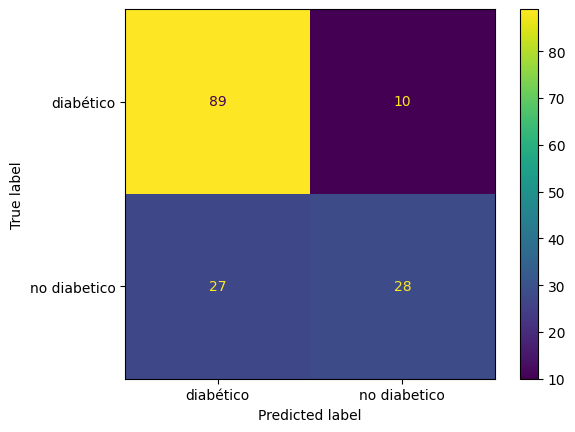

In [24]:
# Matriz de confusión para comprobar nuestras sospechas

Matriz_conf= confusion_matrix(y_test, test_pred_simp)
disp = ConfusionMatrixDisplay(confusion_matrix=Matriz_conf, display_labels=['diabético', 'no diabetico'])
disp.plot()

In [25]:
# Visualizamos los resultados con el arbol de decisión complejo
metricas(y_train, y_test,train_pred_compl,test_pred_compl)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.869707,0.800000,0.841921,0.855615,0.751174,0.932668
Test,0.785714,0.707965,0.772727,0.689655,0.727273,0.818182
Diferencia,0.083993,0.092035,0.069194,0.165960,0.023901,0.114487


EN el random forest complejo vemos que los resultado de las métricas son mejores, sin embargo la diferencia entre los resultado de entrenamiento y test para cada una de las métricas es alto, lo que nos lleva a pensar que el modelo está aprendiendo de los datos de entrenamiento.

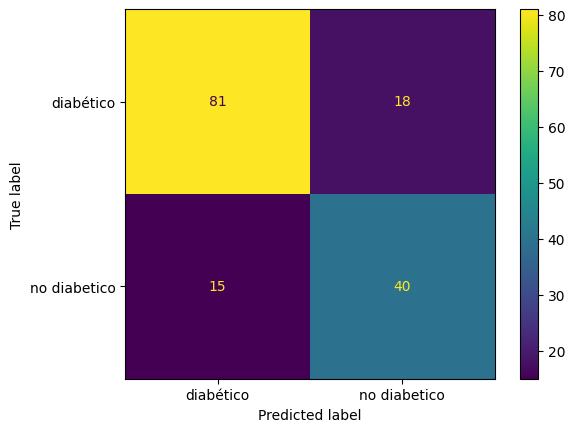

In [26]:
Matriz_conf= confusion_matrix(y_test, test_pred_compl)
disp = ConfusionMatrixDisplay(confusion_matrix=Matriz_conf, display_labels=['diabético', 'no diabetico'])
disp.plot()

Dado que el oibjetivo es mejorar la exactitud, decidimos optimizar el random forest simple al no tener overfitting y tener buenas métricas en general.

In [32]:
# Visualizamos los resultados con el random forest simple
metricas(y_train, y_test,train_pred_simp,test_pred_simp)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.770358,0.581602,0.697628,0.790323,0.460094,0.935162
Test,0.759740,0.602151,0.704040,0.736842,0.509091,0.898990
Diferencia,0.010618,-0.020548,-0.006412,0.053480,-0.048997,0.036172


In [49]:
# Optimización de Random Forest
from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros a ajustar
parametros_grid_rf = {
    "n_estimators": [10,25,50,75,100],
    "max_depth": [1,3,5],
    "min_samples_split": [10,20,30,40]
}

# Aplicar Grid Search con validación cruzada
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                              parametros_grid_rf, cv=5, scoring="accuracy")
grid_search_rf.fit(X_train, y_train)

# Mejor modelo encontrado
best_rf = grid_search_rf.best_estimator_

# Predicción con el mejor modelo
y_pred_best_rf = best_rf.predict(X_test)
acc_best_rf = accuracy_score(y_test, y_pred_best_rf)

print(f"Mejor configuración encontrada: {grid_search_rf.best_params_}")
print(f"Precisión optimizada del Random Forest: {acc_best_rf:.4f}")

Mejor configuración encontrada: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 25}
Precisión optimizada del Random Forest: 0.7532


In [50]:
y_train_best_pred = best_rf.predict(X_train)
y_test_best_pred = best_rf.predict(X_test)

metricas(y_train, y_test,y_train_best_pred,y_test_best_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.842020,0.744063,0.799814,0.849398,0.661972,0.937656
Test,0.753247,0.641509,0.723232,0.666667,0.618182,0.828283
Diferencia,0.088773,0.102554,0.076582,0.182731,0.043790,0.109373


Al optimizar el mdoelo observamos que la diferencia en accuracy entre las metricas de entrenamiento y test nos está indicando que hay un ligero overfitting al ser la diferencia entre ambas de un 8,8%.
La precisión os indica que hay mñas falsos positivos que antes

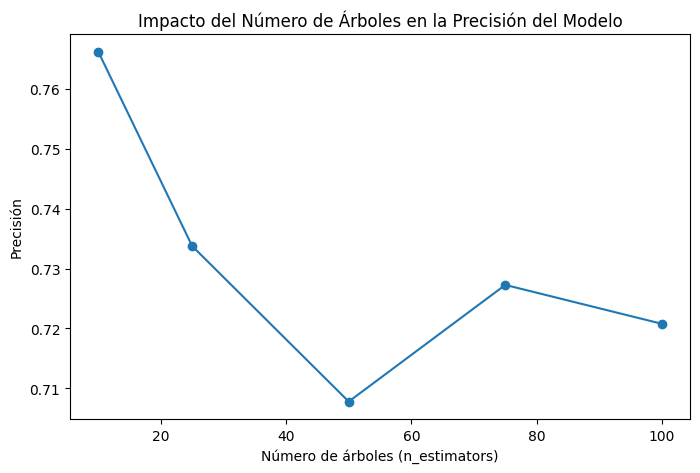

In [51]:
# Análisis del Impacto de los Hiperparámetros
n_estimators_list = [10,25,50,75,100]
accuracy_scores = []

for n in n_estimators_list:
    rf_model = RandomForestClassifier(n_estimators=n, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    acc_rf = accuracy_score(y_test, y_pred_rf)
    accuracy_scores.append(acc_rf)

# Graficar resultados
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_list, accuracy_scores, marker='o', linestyle='-')
plt.xlabel("Número de árboles (n_estimators)")
plt.ylabel("Precisión")
plt.title("Impacto del Número de Árboles en la Precisión del Modelo")
plt.show()
